# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import json
from glob import glob
from matplotlib import pyplot as plt
from tensorflow.keras.applications import vgg16
from random import shuffle
from scipy.special import softmax

print(tf.__version__)


2.15.0


### Useful functions

In [40]:
TRAIN_PREFIX = 'data/fish/train'
ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 
IMG_HEIGHT = 750
IMG_WIDTH = 1200
K = tf.keras.backend

def load_annotations():
    boxes = dict()
    for path in glob('data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                    rect['class'] = label
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=10)
            img = cv2.putText(img.copy(), 
                              annotation['annotations'][i]['class'], 
                              tuple(np.array(pt1)+[0,-7]), 
                              cv2.FONT_HERSHEY_SIMPLEX, 
                              1, 
                              color,
                              4)
        return img
    
    def __draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=3)
            img = cv2.putText(img.copy(), classes['class'][int(rect['label'])] + ': ' + str(rect['label']), tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = __draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        label = list_of_classes == rect['class']
        
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = np.array([*label, 1., dx, dy, dw, dh])
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            label = np.empty(6)
            label[0], label[1], label[2], label[3], label[4], label[5], conf, dx, dy, dw, dh = prediction[row, col]
            label = softmax(label)
#             logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(conf)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(label)),
                                   'labels': label })
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]


def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_tr, y_pr, alpha=0.25, gamma=2.0):
    y_true = y_tr[..., :0]
    y_pred = y_pr[..., :0]

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_true, logits=y_pred
    )
    probs = tf.nn.softmax(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), alpha, (1.0 - alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, gamma) * cross_entropy
    
    return tf.reduce_sum(loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))
    
    # TODO: добавьте функцию потерь для классификации детекции
    classif_loss = classification_loss(y_true, y_pred)
    
    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_classif_loss = K.sum(classif_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    classif_loss = pos_classif_loss / (num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss #+ classif_loss

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

### Визуализируем разметку

In [4]:
boxes = load_annotations()  # загружаем разметку детекций

In [5]:
classes = pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])
list_of_classes = classes['class'].values
classes

class  count
0    alb     27
1    bet      5
2    dol      2
3    lag      2
4  shark      4
5    yft     12

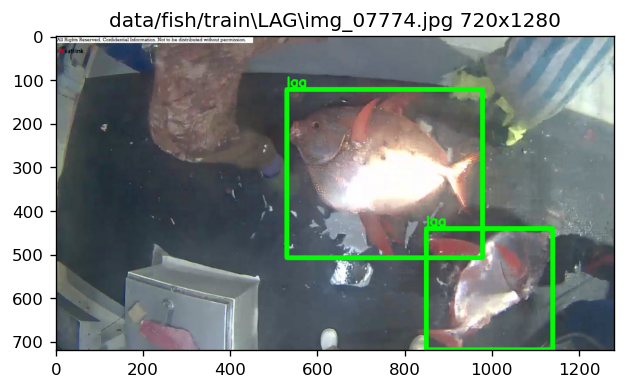

In [6]:
annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

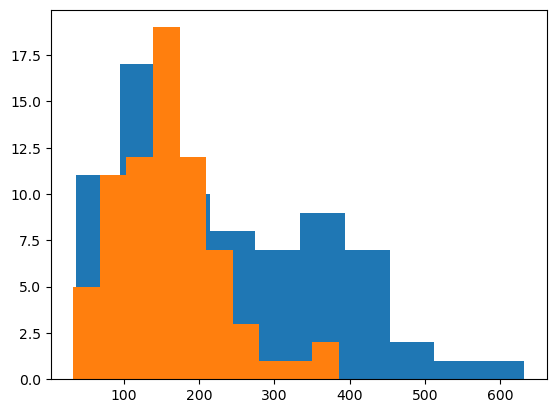

In [7]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [8]:
features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)



(None, 23, 37, 512)


In [9]:
features.layers

In [10]:
features.layers[-1].output

<KerasTensor: shape=(None, 23, 37, 512) dtype=float32 (created by layer 'block5_pool')>

# Сетка якорей (anchor grid)

In [11]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]



# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [12]:
ANCHOR_CENTERS

array([[[  16.30434783,   16.30434783,   16.30434783, ...,
           16.30434783,   16.30434783,   16.30434783],
        [  48.91304348,   48.91304348,   48.91304348, ...,
           48.91304348,   48.91304348,   48.91304348],
        [  81.52173913,   81.52173913,   81.52173913, ...,
           81.52173913,   81.52173913,   81.52173913],
        ...,
        [ 668.47826087,  668.47826087,  668.47826087, ...,
          668.47826087,  668.47826087,  668.47826087],
        [ 701.08695652,  701.08695652,  701.08695652, ...,
          701.08695652,  701.08695652,  701.08695652],
        [ 733.69565217,  733.69565217,  733.69565217, ...,
          733.69565217,  733.69565217,  733.69565217]],

       [[  16.21621622,   48.64864865,   81.08108108, ...,
         1118.91891892, 1151.35135135, 1183.78378378],
        [  16.21621622,   48.64864865,   81.08108108, ...,
         1118.91891892, 1151.35135135, 1183.78378378],
        [  16.21621622,   48.64864865,   81.08108108, ...,
         1118.

### Валидация энкодинга/декодинга якорей

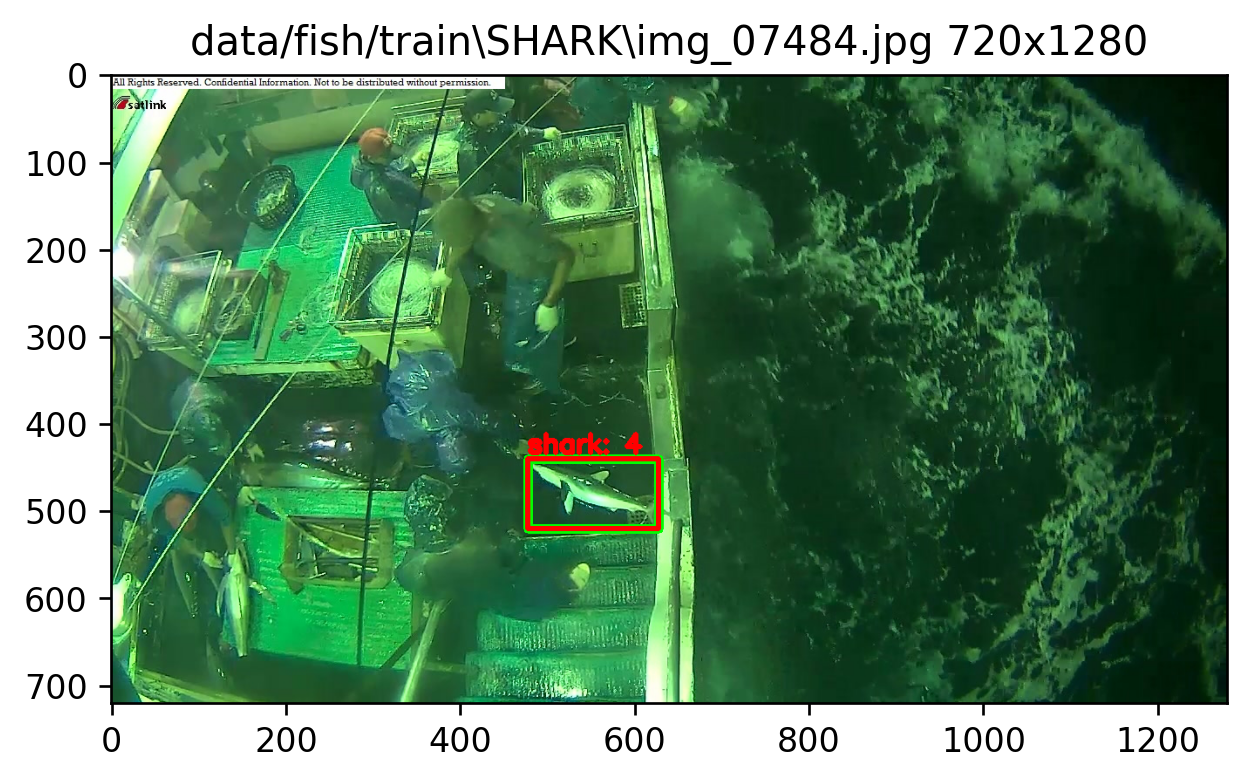

In [13]:
annotation = boxes['shark'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=240)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

## Загрузка данных

## Добавляем выход детектора

In [47]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(11,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0   

## Обучение

In [48]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss, classification_loss, smooth_l1])

In [49]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fish_detector_new.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          callbacks=[checkpoint])

Epoch 1/100
 9/10 [========================>.....] - ETA: 8s - loss: 2.2542 - confidence_loss: 0.8217 - classification_loss: 0.0000e+00 - smooth_l1: 3.6710 
Epoch 1: loss improved from inf to 2.15906, saving model to fish_detector_new.hdf5
10/10 [==============================] - 69s 7s/step - loss: 2.0928 - confidence_loss: 0.8128 - classification_loss: 0.0000e+00 - smooth_l1: 3.5642
Epoch 2/100
 8/10 [======================>.......] - ETA: 14s - loss: 1.4277 - confidence_loss: 0.7277 - classification_loss: 0.0000e+00 - smooth_l1: 2.7691
Epoch 2: loss improved from 2.15906 to 1.39944, saving model to fish_detector_new.hdf5
10/10 [==============================] - 65s 6s/step - loss: 1.3701 - confidence_loss: 0.7180 - classification_loss: 0.0000e+00 - smooth_l1: 2.6773
Epoch 3/100
 7/10 [===================>..........] - ETA: 20s - loss: 1.2063 - confidence_loss: 0.6901 - classification_loss: 0.0000e+00 - smooth_l1: 2.1797
Epoch 3: loss improved from 1.39944 to 1.17759, saving model to

## Результат работы детектора

In [ ]:
# model.load_weights('data/fish/fishdetector_weights.hdf5')

1/1 [==============================] - 1s 927ms/step


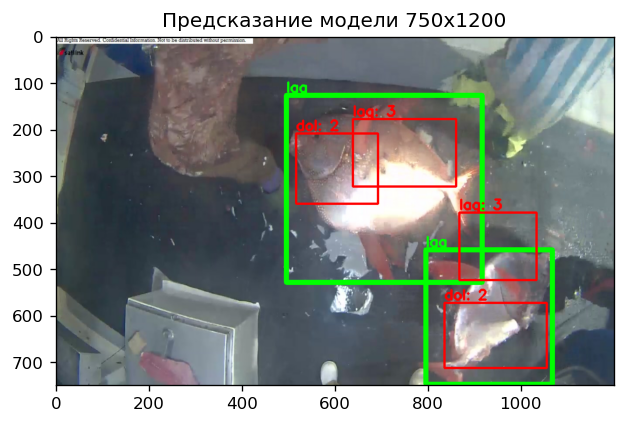

In [53]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

1/1 [==============================] - 1s 976ms/step


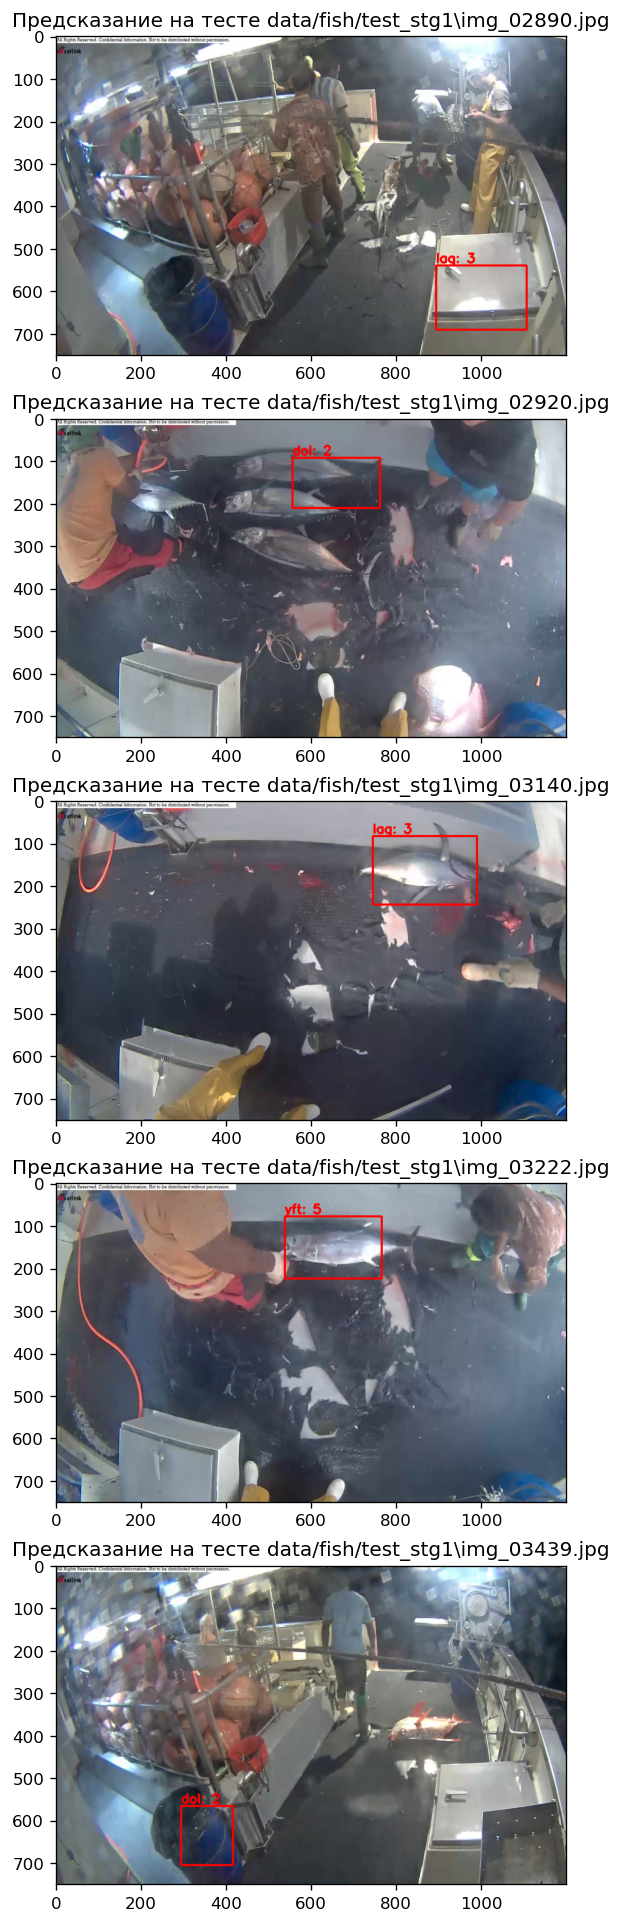

In [55]:
test_images = glob('data/fish/test_stg1/*.jpg')[5:10]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

In [61]:
def make_predictions():
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])
    
    for i, file in enumerate(glob('fish/test_stg1/*.jpg')):
        bn = os.path.basename(file)
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.015)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.1)
        decoded = decoded[0]['labels']

        ptable.loc[i, 'image'] = bn
        ptable.loc[i, 'ALB'] = decoded[5]
        ptable.loc[i, 'BET'] = decoded[1]
        ptable.loc[i, 'DOL'] = decoded[4]
        ptable.loc[i, 'LAG'] = decoded[3]
        ptable.loc[i, 'SHARK'] = decoded[0]
        ptable.loc[i, 'YFT'] = decoded[2]
        ptable.loc[i, 'NoF'] = 0.123081
        ptable.loc[i, 'OTHER'] = 0.079142
        
        if i % 100 == 0:
            print("--------------------------------------------")

    i += 1    
    
    for j, file in enumerate(glob('fish/test_stg2/*.jpg')):
        bn = os.path.basename(file)
        
        bn = "test_stg2/" + bn
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]

        decoded = decode_prediction(pred, conf_thr=0.015)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.1)
        
        decoded = decoded[0]['labels']

        ptable.loc[i + j, 'image'] = bn
        ptable.loc[i + j, 'ALB'] = decoded[5]
        ptable.loc[i + j, 'BET'] = decoded[1]
        ptable.loc[i + j, 'DOL'] = decoded[4]
        ptable.loc[i + j, 'LAG'] = decoded[3]
        ptable.loc[i + j, 'SHARK'] = decoded[0]
        ptable.loc[i + j, 'YFT'] = decoded[2]
        ptable.loc[i + j, 'NoF'] = 0.123081
        ptable.loc[i + j, 'OTHER'] = 0.079142
        
        if i % 500 == 0:
            print("--------------------------------------------")

    return ptable   

## Агрегация результатов

In [62]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки

submitions = make_predictions()
submitions.to_csv("submitions.csv", index=False)
submitions

1/1 [==============================] - 1s 927ms/step
--------------------------------------------
1/1 [==============================] - 1s 1s/step
--------------------------------------------
1/1 [==============================] - 1s 931ms/step
--------------------------------------------
1/1 [==============================] - 1s 921ms/step
--------------------------------------------
1/1 [==============================] - 1s 923ms/step
--------------------------------------------
1/1 [==============================] - 1s 947ms/step
--------------------------------------------
1/1 [==============================] - 1s 952ms/step
--------------------------------------------
1/1 [==============================] - 1s 940ms/step
--------------------------------------------
1/1 [==============================] - 1s 1s/step
--------------------------------------------
1/1 [==============================] - 1s 1s/step
--------------------------------------------
1/1 [========================

image       ALB       BET       DOL       LAG  \
0                  img_00005.jpg  0.890559  0.016191  0.014986  0.006995   
1                  img_00007.jpg  0.863316  0.022293  0.018371  0.009291   
2                  img_00009.jpg  0.165982  0.170052  0.168847  0.169629   
3                  img_00018.jpg   0.87221  0.019064  0.018235  0.008945   
4                  img_00027.jpg  0.819571  0.030054   0.02718  0.014371   
...                          ...       ...       ...       ...       ...   
13148  test_stg2/image_12149.jpg  0.190676  0.201375  0.199205  0.209717   
13149  test_stg2/image_12150.jpg   0.20136  0.199591  0.199688  0.185855   
13150  test_stg2/image_12151.jpg  0.196289  0.199719  0.196407  0.206097   
13151  test_stg2/image_12152.jpg  0.192838  0.203693  0.196903  0.201998   
13152  test_stg2/image_12153.jpg  0.216671  0.199605  0.192817  0.206121   

            NoF     OTHER     SHARK       YFT  
0      0.123081  0.079142   0.00006  0.071209  
1      0.123081  0.079142  0.000122  0.086607  
2      0.123081  0.079142  0.144534  0.180955  
3      0.123081  0.079142  0.000091  0.081456  
4      0.123081  0.079142  0.000143  0.108681  
...         ...       ...       ...       ...  
13148  0.123081  0.079142  0.003886  0.195142  
13149  0.123081  0.079142  0.007423  0.206083  
13150  0.123081  0.079142  0.003545  0.197943  
13151  0.123081  0.079142  0.002865  0.201702  
13152  0.123081  0.079142  0.003582  0.181204  

[13153 rows x 9 columns]